In [3]:
from pyspi.SPILike import SPILike
from pyspi.utils.data_builder.time_series_builder import TimeSeriesBuilderSPI
from pyspi.utils.livedets import get_live_dets_pointing
from pyspi.background.background_model import BackgroundModelPointing
from pyspi.utils.response.spi_response import ResponseRMFNew, ResponseIRFReadRMFNew, SPIDRM

In [4]:
poinitng_ids = ["004400100010"]
import astropy.io.fits as fits
import numpy as np
from pyspi.io.package_data import get_path_of_data_file
with fits.open(get_path_of_data_file("spi_rmf2_rsp_0002.fits")) as f:
   
    elow = f["SPI.-RMF2-RSP"].data["ENERG_LO"]
    ehigh = f["SPI.-RMF2-RSP"].data["ENERG_HI"]

ebounds = np.array(elow, dtype=float)
ebounds = np.append(ebounds, 8000)
ebounds = ebounds[4:30]

rsp_base = ResponseIRFReadRMFNew(0) # irf version 0

Using the irfs that are valid between Start and 03/07/06 06:00:00 (YY/MM/DD HH:MM:SS)


In [5]:
s_all = []
for pointing_id in poinitng_ids:
    bkg = BackgroundModelPointing(pointing_id)
    for det in get_live_dets_pointing(pointing_id, event_types=["single"]):
        rsp1 = ResponseRMFNew.from_pointing(pointing_id, det, 
                                            ebounds, rsp_base)
        sd1 = SPIDRM(rsp1, 0, 0)
        tsb = TimeSeriesBuilderSPI.from_spi_constant_pointing(det, 
                                                            ebounds, 
                                                            pointing_id,
                                                            sd1)
        sl = tsb.to_spectrumlike()
        bkg.set_livetime(det, sl.exposure)
        s_all.append(SPILike.from_spectrumlike(sl, bkg.bkg_count_rate(det, ebounds), free_position=True))

[INFO    ] Interval set to 162293412.46526483-162295608.37850872 for spi_004400100010_0
[WARNING ] No background selection has been made. This plugin will contain no background!
[INFO    ] Auto-probed noise models:
[INFO    ] - observation: poisson
[INFO    ] - background: None
[INFO    ] Auto-probed noise models:
[INFO    ] - observation: poisson
[INFO    ] - background: None
[INFO    ] Interval set to 162293412.55075142-162295608.37154713 for spi_004400100010_1
[WARNING ] No background selection has been made. This plugin will contain no background!
[INFO    ] Auto-probed noise models:
[INFO    ] - observation: poisson
[INFO    ] - background: None
[INFO    ] Auto-probed noise models:
[INFO    ] - observation: poisson
[INFO    ] - background: None
[INFO    ] Interval set to 162293412.46721047-162295608.32854733 for spi_004400100010_2
[WARNING ] No background selection has been made. This plugin will contain no background!
[INFO    ] Auto-probed noise models:
[INFO    ] - observation:

Text(0.5, 0, 'Detected energy [keV]')

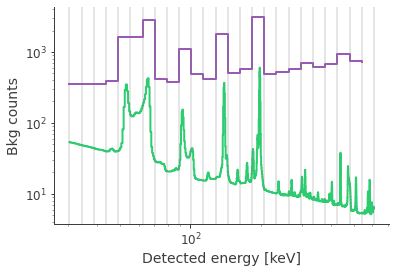

In [6]:
import matplotlib.pyplot as plt
det = 1
plt.step(ebounds[:-1], bkg.bkg_count_rate(det, ebounds), where="post")
plt.step(np.linspace(ebounds[0], ebounds[-1], 1000)[:-1], bkg.bkg_count_rate(det, np.linspace(ebounds[0], ebounds[-1], 1000)))
for e in ebounds:
    plt.axvline(e, alpha=0.2, color="grey")
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Bkg counts")
plt.xlabel("Detected energy [keV]")

In [7]:
# Model
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astromodels import *

pl = Powerlaw()
pl.K.prior = Log_uniform_prior(lower_bound=1e-6, upper_bound=1000)
pl.index.set_uninformative_prior(Uniform_prior) 
ps1 = PointSource('Crab', ra=82.633, dec=22.015, spectral_shape=pl)#83.633
model = Model(ps1)

from astromodels import Parameter
pars = []
for i in range(len(ebounds)-1):
    p = Parameter(
            f"bkg_ratio_ebin_{i}",
            1.0,
            min_value=0,
            max_value=100,
            delta=0.05,
            free=True,
            desc=f"Bkg ratio in ebin {i}",
        )
    p.prior = Log_uniform_prior(lower_bound=0.000001, upper_bound=100)
    model.add_external_parameter(p)

In [8]:
from threeML import DataList, JointLikelihood
datalist = DataList(*s_all)

jl_no_eac = JointLikelihood(model, datalist)

jl_no_eac.fit()

Freeing the position of spi_004400100010_0 and setting priors
Freeing the position of spi_004400100010_1 and setting priors
Freeing the position of spi_004400100010_2 and setting priors
Freeing the position of spi_004400100010_3 and setting priors
Freeing the position of spi_004400100010_4 and setting priors
Freeing the position of spi_004400100010_5 and setting priors
Freeing the position of spi_004400100010_6 and setting priors
Freeing the position of spi_004400100010_7 and setting priors
Freeing the position of spi_004400100010_8 and setting priors
Freeing the position of spi_004400100010_9 and setting priors
Freeing the position of spi_004400100010_10 and setting priors
Freeing the position of spi_004400100010_11 and setting priors
Freeing the position of spi_004400100010_12 and setting priors
Freeing the position of spi_004400100010_13 and setting priors
Freeing the position of spi_004400100010_14 and setting priors
Freeing the position of spi_004400100010_15 and setting priors
Fr

,result,unit
parameter,,
Crab.position.ra,(8.3600 +/- 0.0020) x 10,deg
Crab.position.dec,(2.2014 +/- 0.0020) x 10,deg
Crab.spectrum.main.Powerlaw.K,(1.22 -0.19 +0.22) x 10,1 / (cm2 keV s)
Crab.spectrum.main.Powerlaw.index,-2.17 +/- 0.04,
bkg_ratio_ebin_0,1.257 +/- 0.023,
bkg_ratio_ebin_1,1.335 +/- 0.022,
bkg_ratio_ebin_2,1.426 +/- 0.021,
bkg_ratio_ebin_3,1.632 +/- 0.020,
bkg_ratio_ebin_4,2.160 +/- 0.009,



Correlation matrix:



1.00,-0.05,-0.05,0.02,0.21,0.21,0.21,0.18,0.10,0.08,0.05,0.11,0.10,0.05,0.06,0.06,0.03,0.04,0.03,0.01,0.02,0.02,0.01,0.01,0.01,0.01,0.00,0.00,0.00
-0.05,1.00,-0.01,-0.00,0.13,0.14,0.14,0.12,0.07,0.05,0.04,0.08,0.07,0.04,0.05,0.05,0.02,0.03,0.03,0.01,0.02,0.02,0.01,0.01,0.01,0.01,0.00,0.00,0.00
-0.05,-0.01,1.00,-0.99,-0.47,-0.34,-0.18,-0.03,0.07,0.13,0.14,0.37,0.42,0.30,0.42,0.45,0.24,0.39,0.36,0.15,0.31,0.27,0.23,0.18,0.16,0.13,0.09,0.09,0.07
0.02,-0.00,-0.99,1.00,0.41,0.28,0.12,-0.03,-0.10,-0.15,-0.16,-0.40,-0.45,-0.32,-0.44,-0.47,-0.25,-0.41,-0.37,-0.15,-0.32,-0.28,-0.23,-0.18,-0.17,-0.13,-0.10,-0.09,-0.08
0.21,0.13,-0.47,0.41,1.00,0.41,0.35,0.27,0.11,0.07,0.03,0.01,-0.02,-0.04,-0.07,-0.09,-0.05,-0.09,-0.09,-0.04,-0.09,-0.08,-0.07,-0.05,-0.05,-0.04,-0.03,-0.03,-0.02
0.21,0.14,-0.34,0.28,0.41,1.00,0.35,0.29,0.14,0.10,0.05,0.08,0.05,0.01,-0.00,-0.02,-0.02,-0.03,-0.04,-0.02,-0.04,-0.04,-0.03,-0.03,-0.03,-0.02,-0.02,-0.02,-0.01
0.21,0.14,-0.18,0.12,0.35,0.35,1.00,0.29,0.15,0.12,0.08,0.14,0.12,0.06,0.07,0.06,0.02,0.03,0.02,0.01,0.01,0.01,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00
0.18,0.12,-0.03,-0.03,0.27,0.29,0.29,1.00,0.16,0.13,0.10,0.19,0.17,0.10,0.13,0.12,0.06,0.09,0.07,0.03,0.06,0.04,0.04,0.03,0.02,0.02,0.01,0.01,0.01
0.10,0.07,0.07,-0.10,0.11,0.14,0.15,0.16,1.00,0.09,0.07,0.14,0.13,0.08,0.11,0.10,0.05,0.08,0.07,0.03,0.06,0.05,0.04,0.03,0.03,0.02,0.01,0.01,0.01
0.08,0.05,0.13,-0.15,0.07,0.10,0.12,0.13,0.09,1.00,0.07,0.14,0.15,0.09,0.12,0.12,0.06,0.10,0.09,0.03,0.07,0.06,0.05,0.04,0.03,0.03,0.02,0.02,0.01
0.05,0.04,0.14,-0.16,0.03,0.05,0.08,0.10,0.07,0.07,1.00,0.12,0.13,0.08,0.11,0.11,0.06,0.09,0.08,0.03,0.07,0.06,0.05,0.04,0.03,0.03,0.02,0.02,0.01



Values of -log(likelihood) at the minimum:



,-log(likelihood)
spi_004400100010_0,175.142685
spi_004400100010_1,121.934767
spi_004400100010_10,131.588587
spi_004400100010_11,133.352024
spi_004400100010_12,144.152424
spi_004400100010_13,152.198145
spi_004400100010_14,442.087906
spi_004400100010_15,134.822607
spi_004400100010_16,153.275248
spi_004400100010_17,141.719193



Values of statistical measures:



,statistical measures
AIC,6122.889872
BIC,6239.715889


Crab.position.ra
equal-tail: (8.3601 -0.0020 +0.0021) x 10, hpd: (8.3601 +/- 0.0020) x 10
Crab.position.dec
equal-tail: (2.2014 -0.0020 +0.0019) x 10, hpd: (2.2014 +/- 0.0020) x 10
Crab.spectrum.main.Powerlaw.K
equal-tail: (1.21 -0.18 +0.22) x 10, hpd: (1.21 +/- 0.20) x 10
Crab.spectrum.main.Powerlaw.index
equal-tail: -2.17 +/- 0.04, hpd: -2.17 +/- 0.04
bkg_ratio_ebin_0
equal-tail: 1.257 -0.023 +0.024, hpd: 1.257 -0.021 +0.025
bkg_ratio_ebin_1
equal-tail: 1.336 +/- 0.022, hpd: 1.336 -0.020 +0.024
bkg_ratio_ebin_2
equal-tail: 1.426 +/- 0.021, hpd: 1.426 -0.018 +0.024
bkg_ratio_ebin_3
equal-tail: 1.632 -0.021 +0.019, hpd: 1.632 -0.021 +0.019
bkg_ratio_ebin_4
equal-tail: 2.160 +/- 0.009, hpd: 2.160 -0.010 +0.008
bkg_ratio_ebin_5
equal-tail: 2.436 +/- 0.010, hpd: 2.436 +/- 0.010
bkg_ratio_ebin_6
equal-tail: 2.543 +/- 0.007, hpd: 2.543 +/- 0.007
bkg_ratio_ebin_7
equal-tail: 2.124 +/- 0.020, hpd: 2.124 -0.019 +0.021
bkg_ratio_ebin_8
equal-tail: 2.108 -0.022 +0.021, hpd: 2.108 -0.023 +0.020
b

(                                       value  negative_error  positive_error  \
 Crab.position.ra                   83.600473       -0.019809        0.021154   
 Crab.position.dec                  22.013950       -0.019895        0.019453   
 Crab.spectrum.main.Powerlaw.K      12.244140       -1.895738        2.110688   
 Crab.spectrum.main.Powerlaw.index  -2.168443       -0.040941        0.043320   
 bkg_ratio_ebin_0                    1.256761       -0.022415        0.023926   
 bkg_ratio_ebin_1                    1.335474       -0.021533        0.022682   
 bkg_ratio_ebin_2                    1.425743       -0.020169        0.021736   
 bkg_ratio_ebin_3                    1.631871       -0.020215        0.019936   
 bkg_ratio_ebin_4                    2.160018       -0.009046        0.008890   
 bkg_ratio_ebin_5                    2.436060       -0.009674        0.009769   
 bkg_ratio_ebin_6                    2.542814       -0.007319        0.007226   
 bkg_ratio_ebin_7           

[<Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>]

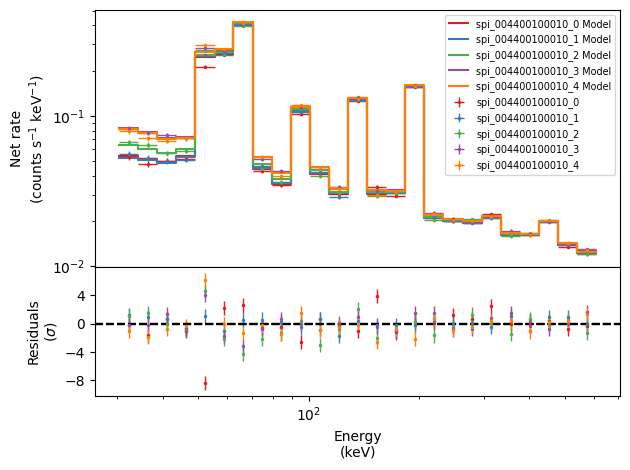

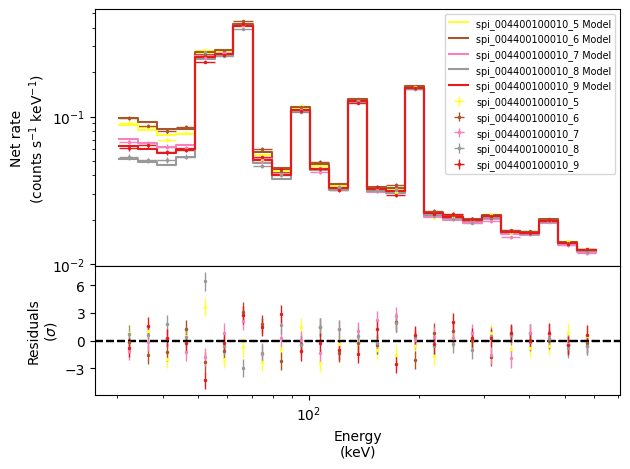

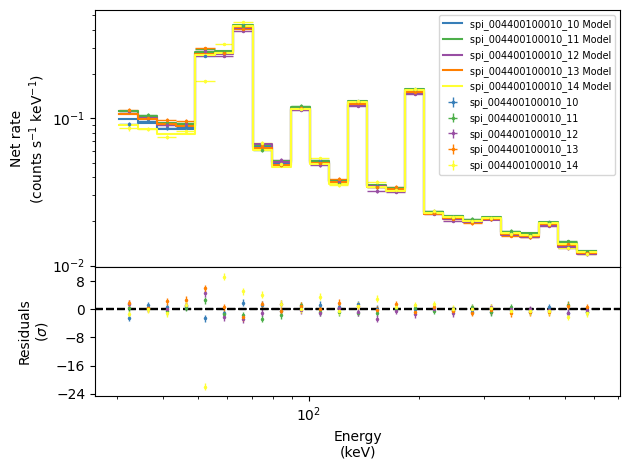

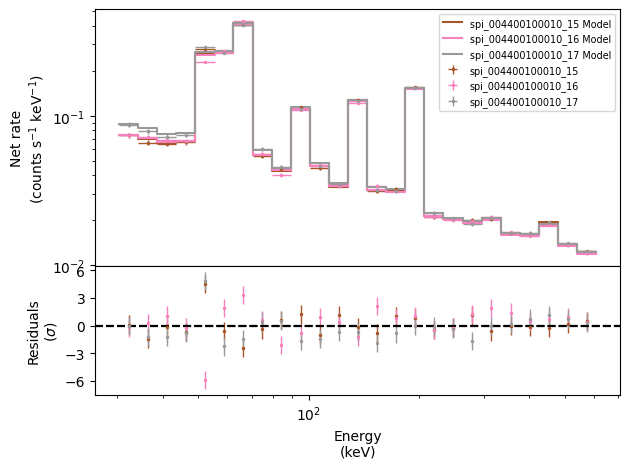

In [9]:
from threeML import *
plt.style.use("default")
jl_no_eac.restore_best_fit()
display_spectrum_model_counts(jl_no_eac, step=True, data_per_plot=5)

processing MLE analyses:   0%|          | 0/1 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

processing Bayesian analyses: 0it [00:00, ?it/s]

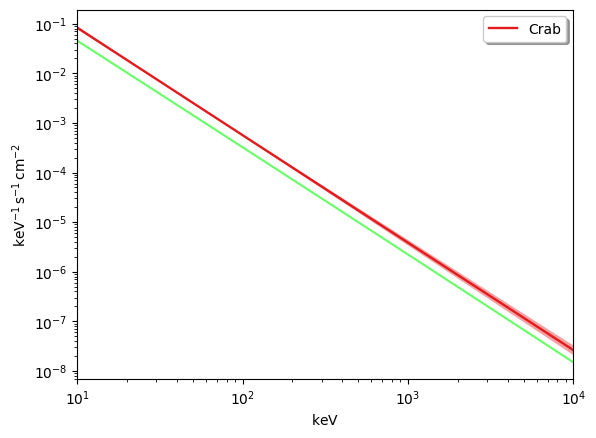

In [22]:
fig = plot_spectra(jl_no_eac.results, flux_unit="1/(cm2 s keV)")
ax = fig.get_axes()[0]

def crab(E):
    C = 6.44*10**-4
    Eb = 100
    alpha = 2.08
    beta = 2.23
    return C/((E/Eb)**(alpha)+(E/Eb)**beta)

evals = np.geomspace(10,10000, 100)
ax.plot(evals, crab(evals), color="lime", alpha=0.6)

# livetime is not correct yet (dead time missing)